In [113]:
import pandas as pd
import numpy as np
import pm4py
import seaborn as sns
import matplotlib.pyplot as plt
from fontTools.misc.plistlib import end_array
from matplotlib.pyplot import xlabel

sns.set_theme()

import warnings
warnings.simplefilter('ignore')

# Sepsis Analysis

## Load Data

In [2]:
sepsis_df = pm4py.read_xes("./Sepsis Cases - Event Log.xes")

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2544.52it/s]


In [3]:
activity_key = "concept:name"
timestamp_key = "time:timestamp"
case_id_key = "case:concept:name"
organization_key = "org:group"
lifecycle_key = "lifecycle:transition"

In [4]:
sepsis_df.filter(like=":").columns.tolist()

['org:group',
 'concept:name',
 'time:timestamp',
 'lifecycle:transition',
 'case:concept:name']

In [5]:
sepsis_event_log = pm4py.convert_to_event_log(sepsis_df, case_id_key=case_id_key,
                                              activity_key=activity_key,
                                              timestamp_key=timestamp_key)

## Basic Information

In [6]:
sepsis_df.shape

(15214, 32)

In [230]:
sepsis_df[activity_key].unique()

array(['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage',
       'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC',
       'Release A', 'Return ER', 'Admission IC', 'Release B', 'Release C',
       'Release D', 'Release E'], dtype=object)

In [235]:
sepsis_df[sepsis_df[activity_key]!="Leucocytes"]

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
5,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Sepsis Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,False,complete,NaN,False,False,False,LNA,NaN,NaN,NaN
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN


### Trace Information

In [7]:
trace_info = sepsis_df[[case_id_key, activity_key, timestamp_key, organization_key, lifecycle_key]]
print(f"Number of unique cases: {trace_info[case_id_key].nunique()}")
print(f"Number of unique activities: {trace_info[activity_key].nunique()}")

Number of unique cases: 1050
Number of unique activities: 16


In [8]:
additional_info = sepsis_df.loc[:, ~sepsis_df.columns.isin([case_id_key, activity_key, timestamp_key, organization_key, lifecycle_key])]

### Additional Information

In [9]:
sirs_mask = additional_info.columns.str.contains("SIRS")
diagnostic_mask = additional_info.columns.str.contains("Diagnostic")
lab_values = additional_info.columns.str.contains("Leucocytes|CRP") | additional_info.columns.str.startswith("LacticAcid")
age_mask = additional_info.columns.str.contains("Age")
diagnose_mask = additional_info.columns.str.contains("Diagnose")
suspected_infection_mask = additional_info.columns.str.contains("InfectionSuspected")
symptoms_mask = additional_info.columns.str.contains("DisfuncOrg|Hypotensie|Oligurie|Hypoxie")
infusion_mask = additional_info.columns.str.contains("Infusion")

combined_mask = (sirs_mask | diagnostic_mask | lab_values |
                 age_mask | diagnose_mask | suspected_infection_mask
                 | symptoms_mask | infusion_mask)

other_attributes = additional_info.loc[:, ~combined_mask]

In [10]:
print(f"Number of SIRS related attributes: {sirs_mask.sum()}")
print(f"Number of Diagnostic related attributes: {diagnostic_mask.sum()}")
print(f"Number of Lab Values related attributes: {lab_values.sum()}")
print(f"Number of Age related attributes: {age_mask.sum()}")
print(f"Number of Diagnose related attributes: {diagnose_mask.sum()}")
print(f"Number of Suspected Infection related attributes: {suspected_infection_mask.sum()}")
print(f"Number of Symptoms related attributes: {symptoms_mask.sum()}")
print(f"Number of Infusion related attributes: {infusion_mask.sum()}")

Number of SIRS related attributes: 5
Number of Diagnostic related attributes: 11
Number of Lab Values related attributes: 3
Number of Age related attributes: 1
Number of Diagnose related attributes: 1
Number of Suspected Infection related attributes: 1
Number of Symptoms related attributes: 4
Number of Infusion related attributes: 1


In [11]:
sepsis_df[sepsis_df['concept:name']=='ER Registration'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 0 to 15211
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   InfectionSuspected         1050 non-null   object             
 1   org:group                  1050 non-null   object             
 2   DiagnosticBlood            1050 non-null   object             
 3   DisfuncOrg                 1050 non-null   object             
 4   SIRSCritTachypnea          1050 non-null   object             
 5   Hypotensie                 1050 non-null   object             
 6   SIRSCritHeartRate          1050 non-null   object             
 7   Infusion                   1050 non-null   object             
 8   DiagnosticArtAstrup        1050 non-null   object             
 9   concept:name               1050 non-null   object             
 10  Age                        995 non-null    float64            
 11  Diagnost

## Statistics on Activities and Cases

### Activities

In [12]:
activity_counts = sepsis_df[activity_key].value_counts().reset_index().rename(columns={'concept:name':'Activity', 'count':'Count'})
activity_counts['RelativeCount'] = (activity_counts['Count'] / activity_counts['Count'].sum())*100
activity_counts

,Activity,Count,RelativeCount
0,Leucocytes,3383,22.236098
1,CRP,3262,21.440778
2,LacticAcid,1466,9.635862
3,Admission NC,1182,7.769160
4,ER Triage,1053,6.921257
5,ER Registration,1050,6.901538
6,ER Sepsis Triage,1049,6.894965
7,IV Antibiotics,823,5.409491
8,IV Liquid,753,4.949389
9,Release A,671,4.410411


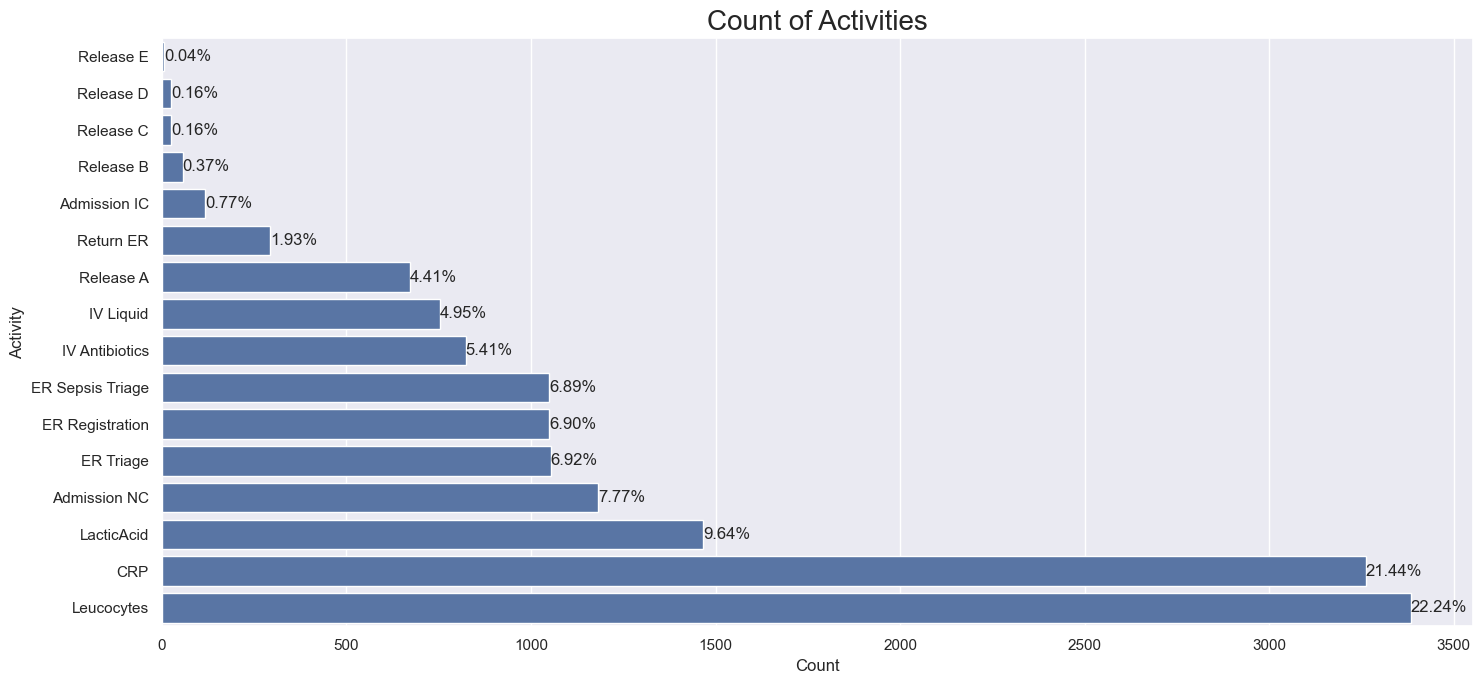

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
sns.barplot(data=activity_counts.sort_values(by=["Count"]), y='Activity', x='Count', ax=ax)
ax.set_title('Count of Activities', fontsize=20)
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax.bar_label(ax.containers[0], labels=[f"{x:.2f}%" for x in activity_counts.sort_values(by=["Count"])['RelativeCount']])

plt.tight_layout()
plt.show()

In [14]:
start_activities = pm4py.get_start_activities(sepsis_event_log, activity_key=activity_key)
start_activities = pd.DataFrame.from_dict(start_activities, orient='index', columns=['Count']).reset_index().rename(columns={'index':'Activity'})
start_activities['RelativeCount'] = (start_activities['Count'] / start_activities['Count'].sum())*100
start_activities.sum()

Activity         ER RegistrationIV LiquidER TriageCRPER Sepsis ...
Count                                                         1050
RelativeCount                                                100.0
dtype: object

In [15]:

pm4py.get_end_activities(sepsis_event_log, activity_key=activity_key)
end_activities = pm4py.get_end_activities(sepsis_event_log, activity_key=activity_key)
end_activities = pd.DataFrame.from_dict(end_activities, orient='index', columns=['Count']).reset_index().rename(columns={'index':'Activity'})
end_activities['RelativeCount'] = (end_activities['Count'] / end_activities['Count'].sum())*100

end_activities

,Activity,Count,RelativeCount
0,Release A,393,37.428571
1,Return ER,291,27.714286
2,IV Antibiotics,87,8.285714
3,Release B,55,5.238095
4,ER Sepsis Triage,49,4.666667
5,Leucocytes,44,4.190476
6,IV Liquid,12,1.142857
7,Release C,19,1.809524
8,CRP,41,3.904762
9,LacticAcid,24,2.285714


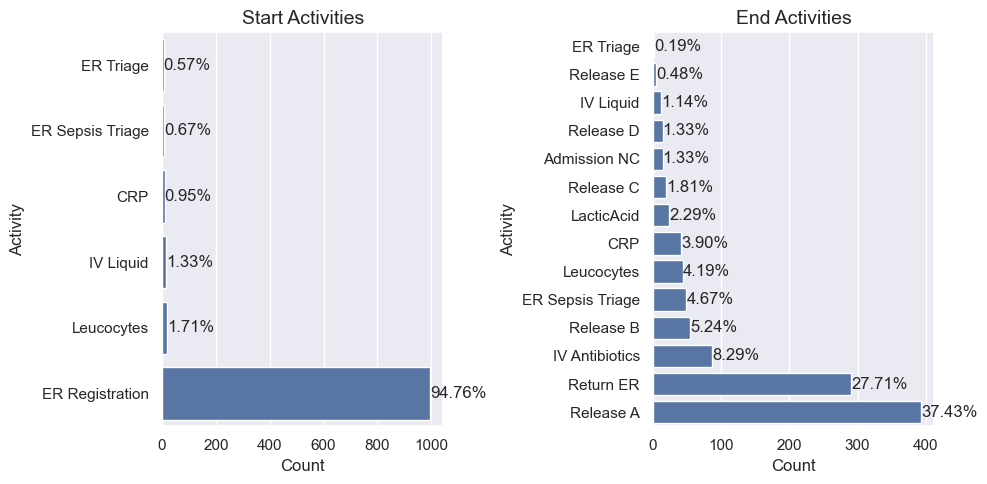

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data=start_activities.sort_values(by=["Count"]), y='Activity', x='Count', ax=ax[0])
ax[0].set_title('Start Activities', fontsize=14)
#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45
ax[0].bar_label(ax[0].containers[0], labels=[f"{x:.2f}%" for x in start_activities.sort_values(by=["Count"])['RelativeCount']])
sns.barplot(data=end_activities.sort_values(by=["Count"]), y='Activity', x='Count', ax=ax[1])
ax[1].set_title('End Activities', fontsize=14)
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45
ax[1].bar_label(ax[1].containers[0], labels=[f"{x:.2f}%" for x in end_activities.sort_values(by=["Count"])['RelativeCount']])
plt.tight_layout()
plt.show()


In [17]:
end_activities[end_activities['Activity'].str.startswith("Release")].sum()

Activity         Release ARelease BRelease CRelease DRelease E
Count                                                      486
RelativeCount                                        46.285714
dtype: object

### Cases

In [18]:
sepsis_df[case_id_key].unique()

array(['A', 'B', 'C', ..., 'JNA', 'KNA', 'LNA'],
      shape=(1050,), dtype=object)

In [19]:
pm4py.get_case_duration(sepsis_event_log, case_id="A")

964759.0

In [20]:
cases = sepsis_df[[timestamp_key, activity_key, case_id_key]].groupby(case_id_key).agg(
    case_start=(timestamp_key, 'min'),
    case_second_to_last=(timestamp_key, lambda x: x.sort_values(ascending=True).iloc[-2]),
    case_end=(timestamp_key, 'max'),
    num_events=(activity_key, 'count')
).reset_index()

cases['case_duration_days'] = cases['case_end'] - cases['case_start']
cases['case_duration'] = cases['case_duration_days'].dt.total_seconds()
cases['case_duration_second_to_last_to_end_days'] = (cases['case_end'] - cases['case_second_to_last'])
cases['case_duration_second_to_last_to_end'] = cases['case_duration_second_to_last_to_end_days'].dt.total_seconds()

In [21]:
cases.sort_values(by=['case_duration'], ascending=True).head(1)

,case:concept:name,case_start,case_second_to_last,case_end,num_events,case_duration_days,case_duration,case_duration_second_to_last_to_end_days,case_duration_second_to_last_to_end
652,Q,2013-12-15 14:17:05+00:00,2013-12-15 14:18:49+00:00,2013-12-15 14:19:07+00:00,3,0 days 00:02:02,122.0,0 days 00:00:18,18.0


In [22]:
cases.sort_values(by=['case_duration'], ascending=False).head(1)

,case:concept:name,case_start,case_second_to_last,case_end,num_events,case_duration_days,case_duration,case_duration_second_to_last_to_end_days,case_duration_second_to_last_to_end
300,HG,2013-12-13 11:58:49+00:00,2013-12-18 13:30:00+00:00,2015-02-08 19:45:18+00:00,15,422 days 07:46:29,36488789.0,417 days 06:15:18,36051318.0


In [23]:
sepsis_df[sepsis_df[case_id_key]=='HG'][[timestamp_key, activity_key]]

,time:timestamp,concept:name
2510,2013-12-13 11:58:49+00:00,ER Registration
2511,2013-12-13 12:02:25+00:00,ER Triage
2512,2013-12-13 12:02:44+00:00,ER Sepsis Triage
2513,2013-12-13 12:13:00+00:00,CRP
2514,2013-12-13 12:13:00+00:00,Leucocytes
2515,2013-12-13 12:13:00+00:00,LacticAcid
2516,2013-12-13 13:51:31+00:00,IV Antibiotics
2517,2013-12-13 13:52:32+00:00,Admission NC
2518,2013-12-14 14:08:34+00:00,Admission NC
2519,2013-12-16 08:00:00+00:00,Leucocytes


In [24]:
case_times = pm4py.get_all_case_durations(sepsis_event_log, activity_key=activity_key, timestamp_key=timestamp_key, case_id_key=case_id_key)
case_times = [x/(60*60*24) for x in case_times]  # Convert to nanoseconds

In [25]:
print(f"Average Case Duration (in days): {pd.Series(case_times).mean()}")
print(f"Median Case Duration (in days): {pd.Series(case_times).median()}")
print(f"Max Case Duration (in days): {pd.Series(case_times).max()}")
print(f"Min Case Duration (in days): {pd.Series(case_times).min()}")


Average Case Duration (in days): 28.469341236772486
Median Case Duration (in days): 5.343385416666667
Max Case Duration (in days): 422.3239467592593
Min Case Duration (in days): 0.001412037037037037


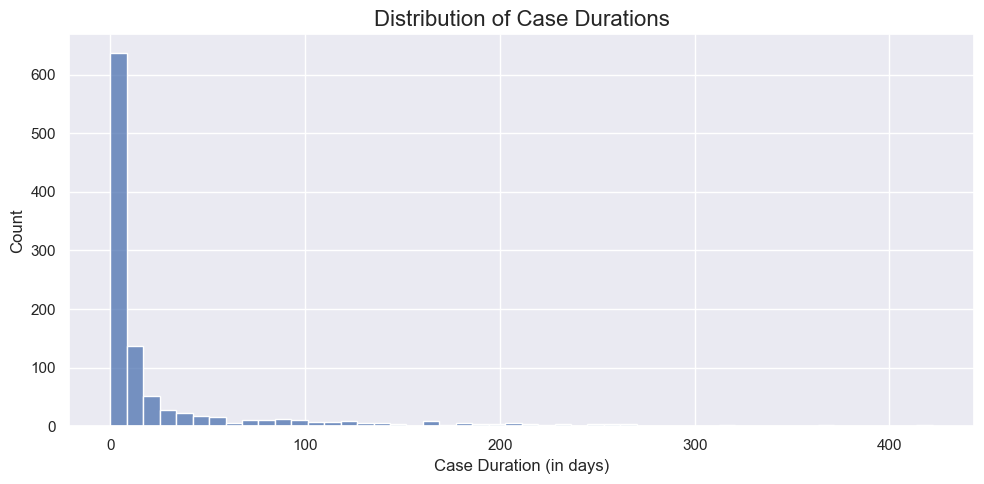

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.histplot(case_times, bins=50, ax=ax)
ax.set_title('Distribution of Case Durations', fontsize=16)
ax.set_xlabel('Case Duration (in days)', fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
#Todo: analyse the duration of the second to last activity to the end activity to see if there are major outliers

In [28]:
time_to_last =  cases['case_duration_second_to_last_to_end']
time_to_last = [x/(60*60*24) for x in time_to_last]  # Convert to nanoseconds

In [51]:
cases[['case:concept:name', 'case_duration', 'case_duration_second_to_last_to_end_days']].sort_values(by=['case_duration_second_to_last_to_end_days'], ascending=False).head(10)

,case:concept:name,case_duration,case_duration_second_to_last_to_end_days
300,HG,36488789.0,417 days 06:15:18
853,VAA,36449207.0,414 days 23:00:15
1042,ZS,34467003.0,397 days 00:08:54
484,LS,34298070.0,394 days 04:39:26
815,UBA,33434200.0,372 days 00:14:55
17,AI,31474239.0,359 days 12:38:36
295,HDA,31531116.0,357 days 02:58:24
478,LN,29601855.0,336 days 20:12:50
419,KE,29031830.0,331 days 03:54:09
23,AL,27691388.0,313 days 15:16:14


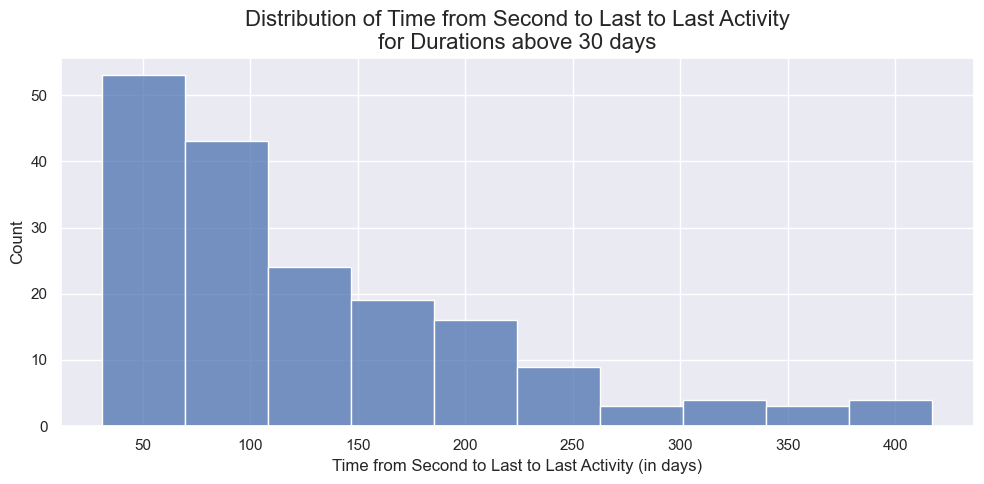

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.histplot([x for x in time_to_last if x>30])
ax.set_title('Distribution of Time from Second to Last to Last Activity\nfor Durations above 30 days', fontsize=16)
ax.set_xlabel('Time from Second to Last to Last Activity (in days)', fontsize=12)
plt.tight_layout()
plt.show()

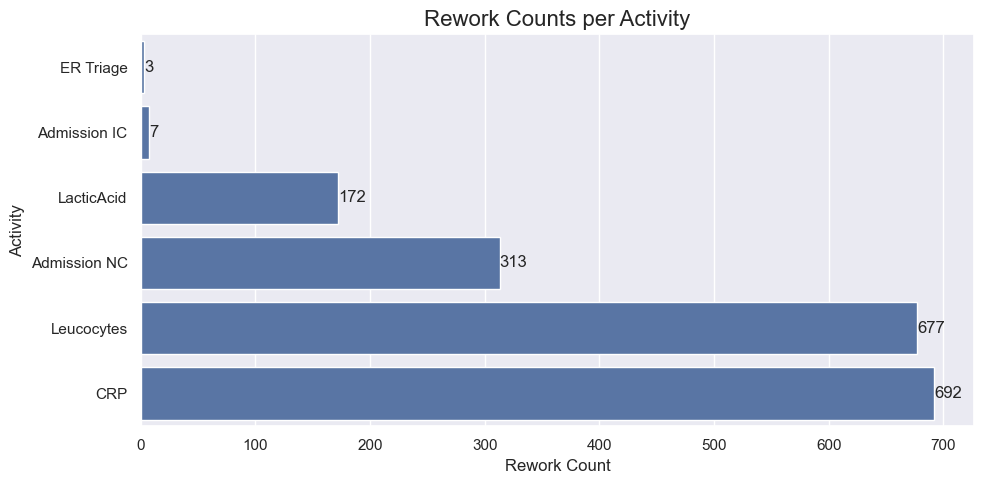

In [267]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
rework_counts = pm4py.get_rework_cases_per_activity(sepsis_event_log, activity_key=activity_key)
rework_counts_df = pd.DataFrame.from_dict(rework_counts, orient='index', columns=['Rework Count']).reset_index().rename(columns={'index':'Activity'})
sns.barplot(data=rework_counts_df.sort_values(by=['Rework Count']), y='Activity', x='Rework Count', ax=ax)
ax.set_title('Rework Counts per Activity', fontsize=16)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

## Dotted Chart

In [236]:
# calculate the time from case start for each event

def calculate_time_from_case_start(event_log:pd.DataFrame, case_id_key, timestamp_key):
    # get the case start and end time for each case
    case_group = event_log.groupby(case_id_key).agg(
        case_start_time=(timestamp_key, 'min'),
        case_end_time=(timestamp_key, 'max')
    )


    # merge the case start times back to the event log
    event_log = event_log.merge(case_group, on=case_id_key, how='left')

    # calculate the time from case start for each event
    event_log['time_from_case_start'] = (event_log[timestamp_key] - event_log['case_start_time']).dt.total_seconds()/(60*60)  # in hours
    # log scale
    # event_log['time_from_case_start'] = event_log['time_from_case_start'].apply(lambda x: np.log1p(x))

    event_log['case_cat'] = event_log[case_id_key].astype('category').cat.codes

    return event_log


In [237]:
events_with_time = calculate_time_from_case_start(sepsis_df, case_id_key, timestamp_key)

In [238]:
# get day of week from date
events_with_time['day_of_week'] = events_with_time[timestamp_key].dt.day_name()
# get hour of day from date
events_with_time['hour_of_day'] = events_with_time[timestamp_key].dt.hour
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
activity_order = ['ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Return ER', 'Admission NC', 'Admission IC', 'IV Liquid', 'IV Antibiotics', 'Leucocytes', 'CRP', 'LacticAcid', 'Release A', 'Release B', 'Release C', 'Release D', 'Release E']

In [261]:
# recategorize the activity

# get 'ER Registration', 'ER Triage' and entries 'ER Sepsis Triage'
er_activites = events_with_time[events_with_time[activity_key].isin(['ER Registration', 'ER Triage', 'ER Sepsis Triage'])].index

# get 'Admission NC' and 'Admission IC'
addmission_activities = events_with_time[events_with_time[activity_key].isin(['Admission NC', 'Admission IC'])].index

# get 'Release A', 'Release B', 'Release C', 'Release D', 'Release E'
release_activities = events_with_time[events_with_time[activity_key].str.startswith('Release')].index

# get 'Leucocytes', 'CRP' and 'LacticAcid'
lab_activities = events_with_time[events_with_time[activity_key].isin(['Leucocytes', 'CRP', 'LacticAcid'])].index

# get 'IV Liquid' and 'IV Antibiotics'
iv_activities = events_with_time[events_with_time[activity_key].isin(['IV Liquid', 'IV Antibiotics'])].index

# get return ER
return_er_activities = events_with_time[events_with_time[activity_key].isin(['Return ER'])].index

events_with_time['Activity Group'] = events_with_time[activity_key]
events_with_time.loc[er_activites, 'Activity Group'] = 'ER Activities'
events_with_time.loc[addmission_activities, 'Activity Group'] = 'Admission'
events_with_time.loc[release_activities, 'Activity Group'] = 'Release'
events_with_time.loc[lab_activities, 'Activity Group'] = 'Lab Tests'
events_with_time.loc[iv_activities, 'Activity Group'] = 'IV Treatment'
events_with_time.loc[return_er_activities, 'Activity Group'] = 'Return ER'

acitivity_order_reduced = ['ER Activities', 'Admission', 'IV Treatment', 'Lab Tests', 'Return ER', 'Release']

In [262]:
sepsis_df[activity_key].unique()

array(['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage',
       'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC',
       'Release A', 'Return ER', 'Admission IC', 'Release B', 'Release C',
       'Release D', 'Release E'], dtype=object)

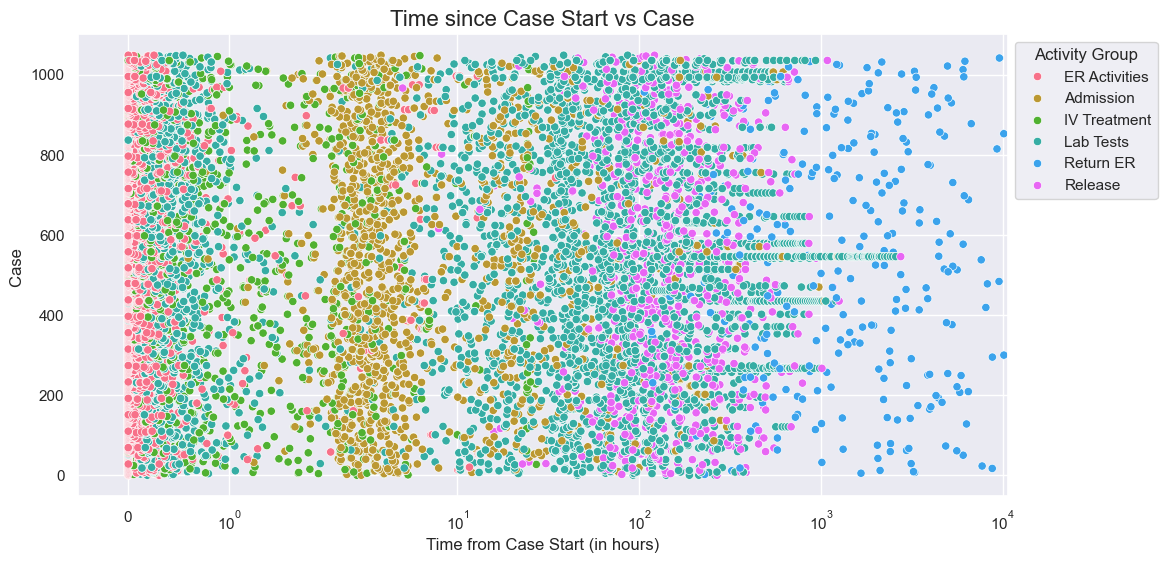

In [264]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.scatterplot(data=events_with_time, x='time_from_case_start', y='case_cat', hue='Activity Group', hue_order=acitivity_order_reduced, ax=ax, palette='husl')
ax.set_title("Time since Case Start vs Case", fontsize=16)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Time from Case Start (in hours)", fontsize=12)
ax.set_ylabel("Case ", fontsize=12)
ax.set_xscale('symlog')
ax.set_xlim(left=-0.5)

fig.savefig("./sepsis_dotted_chart.png", bbox_inches='tight')